### Data Exploration

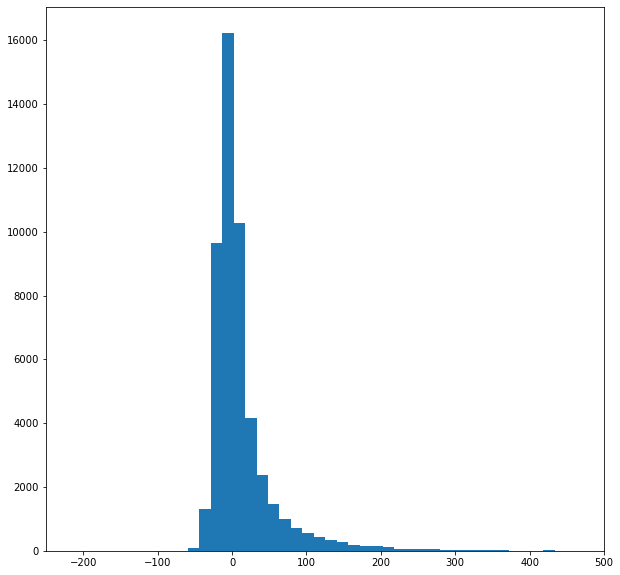

In [118]:
# Lots of data points around zero
plt.hist(flights['arr_delay'], bins=100) 
#plt.ylim(0, 2000)
plt.xlim(-250, 500)
plt.show()

# Modelling

In [ ]:
### Garbage Collect
import gc
gc.collect()

### Load Packages

In [77]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime 
import datetime as dt
import matplotlib.pyplot as plt

### Load and Prep Data

In [226]:
# Prep data for ML

#Load balanced data
#Even re-sample of delay and no delay from orig dataset
#flights = pd.read_csv(r'C:\Users\Ryan\Lighthouse\Bootcamp\w6\midterm\Data\cleaned\mini\mini_sample.csv', delimiter=',', low_memory=False)
flights = pd.read_csv(r'C:\Users\Ryan\Lighthouse\Bootcamp\w6\midterm\Data\cleaned\mini\new5\twohund_sample.csv', delimiter=',', low_memory=False)
flights.head()

#Add Date Featues to table
flights['year'] = pd.to_datetime(flights['fl_date']).dt.year
flights['quarter'] = pd.to_datetime(flights['fl_date']).dt.quarter
flights['month'] = pd.to_datetime(flights['fl_date']).dt.month
flights['day_of_month'] = pd.to_datetime(flights['fl_date']).dt.day
flights['day_of_week'] = pd.to_datetime(flights['fl_date']).dt.dayofweek

#Add time features to table
flights['crs_dep_hour'] = pd.to_datetime(flights['crs_dep_time'], format='%H%M', errors ='coerce').dt.hour
flights['crs_arr_hour'] = pd.to_datetime(flights['crs_dep_time'], format='%H%M', errors ='coerce').dt.hour

#Add column with delay or no delay
flights['arr_delay_flag'] = flights['arr_delay'].map(lambda x: 1 if x > 0 else 0)

#Import weather data
weather = pd.read_csv(r'C:\Users\Ryan\Lighthouse\Bootcamp\w6\midterm\Weather2\weather_table.csv', delimiter=',', low_memory=False)

#Add weather data to flights
flights = pd.merge(flights, weather, how='left', left_on=['fl_date', 'dest'], right_on = ['date_time', 'location'])

# Drop nas
flights = flights[flights['weather_type'].notna()]

#Remove duplicate columns
flights = flights.loc[:,~flights.columns.duplicated()]

# Classifier Modelling for Delay and No Delay

### XGBoost with One Hot Encoding - 50,000 Balanced Dataset

In [8]:
# XGB Classifier - Balanced Dataset - Onehot Encoding - Cleaned Up Version
# Weather Added

# Select Features and Assign X and y
cols = ['distance', 'crs_arr_time', 'crs_dep_time', 'day_of_month', 'month', 'day_of_week', 'op_unique_carrier', 'origin', 'dest', 'weather_type', ]      
#'tail_num' , 'crs_dest_time', 'op_carrier_fl_num', 'op_carrier_fl_num'
# crs_dep_time', crs_dep_hour', 'crs_arr_hour''crs_arr_time', 'crs_elapsed_time', 'crs_dep_time', 'dest', 'tail_num', 
#crs_arr_time', 'op_unique_carrier', 'crs_dep_hour', 'crs_arr_time', 'crs_elapsed_time']
X = flights[cols]
y = flights['arr_delay_flag']

# Onehot encoding
cat_vars = ['day_of_month', 'month', 'day_of_week', 'op_unique_carrier', 'origin', 'dest', 'weather_type']
X = pd.get_dummies(X, columns=cat_vars)

# Make train-test split and scale if needed
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#Xsc = scaler.fit_transform(X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=101)

#Model
import xgboost as xgb
model = xgb.XGBClassifier(objective = 'reg:squarederror')
model = model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#Evaluate
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_recall_curve
from sklearn.metrics import average_precision_score,roc_auc_score, confusion_matrix, plot_confusion_matrix, precision_score
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_pred))

C:\Users\Ryan\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


              precision    recall  f1-score   support

           0       0.52      0.50      0.51      7461
           1       0.52      0.55      0.53      7539

    accuracy                           0.52     15000
   macro avg       0.52      0.52      0.52     15000
weighted avg       0.52      0.52      0.52     15000

Accuracy: 0.5208
F1 Score: 0.533912592400467
Recall: 0.5460936463721979
Precision: 0.522263097805404
AUC Score: 0.5206677855235873


### XGB Label Encoding Feature Importance

In [26]:
# XGB Classifier - Balanced Dataset - Onehot Encoding
# New features added all

# Select Features and Assign X and y
cols = ['distance', 'crs_arr_time', 'crs_dep_time', 'day_of_month', 'month', 'day_of_week', 'op_unique_carrier', 'origin', 'dest', 'weather_type', 
       'origin_fl_density', 'dest_fl_density',
       'predicted_speed_mi/min', 'actual_speed_mi/min', 'origin_passengers/mo',
       'dest_passengers/mo', 'origin_freight/mo', 'dest_freight/mo',
       'origin_intl_dep/mo', 'dest_intl_dep/mo', 'origin_intl_arr/mo',
       'dest_intl_arr/mo', 'origin_airport_size', 'dest_airport_size',
       'size_x', 'dest_airport_size.1', 'dist_group', 'season',
       'dep_early_morning', 'quarter']      
X = flights[cols]
y = flights['arr_delay_flag']

# encode categorical columns
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
cat_vars = X.select_dtypes(include= 'object').columns.tolist()
for col in cat_vars:
    X[col] = label_encoder.fit_transform(X[col])

# Onehot encoding
#cat_vars = ['day_of_month', 'month', 'day_of_week', 'op_unique_carrier', 'origin', 'dest', 'weather_type']
#X = pd.get_dummies(X, columns=cat_vars)

# Make train-test split and scale if needed
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#Xsc = scaler.fit_transform(X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=101)

#Model
import xgboost as xgb
model = xgb.XGBClassifier(objective = 'reg:squarederror')
model = model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#Evaluate
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_recall_curve
from sklearn.metrics import average_precision_score,roc_auc_score, confusion_matrix, plot_confusion_matrix, precision_score
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_pred))

<ipython-input-26-b9f253f47b02>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = label_encoder.fit_transform(X[col])


              precision    recall  f1-score   support

           0       0.51      0.50      0.51      7461
           1       0.52      0.53      0.52      7539

    accuracy                           0.52     15000
   macro avg       0.52      0.52      0.52     15000
weighted avg       0.52      0.52      0.52     15000

Accuracy: 0.5154666666666666
F1 Score: 0.5220936349289846
Recall: 0.5265950391298581
Precision: 0.517668535663059
AUC Score: 0.5154084966457493


### Feature Importance

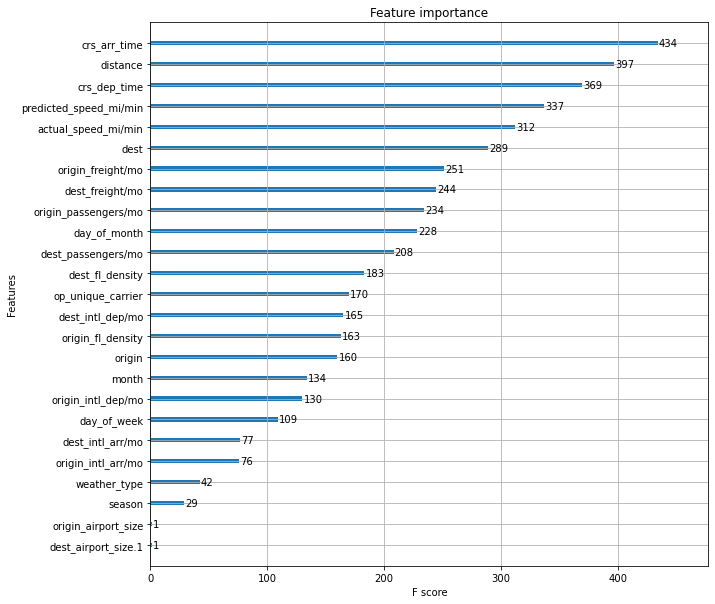

In [29]:
# Plot XGB Feature Importance
# .set_yticklabels(cols)
fig = xgb.plot_importance(model)
#fig.set_yticklabels(cols)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

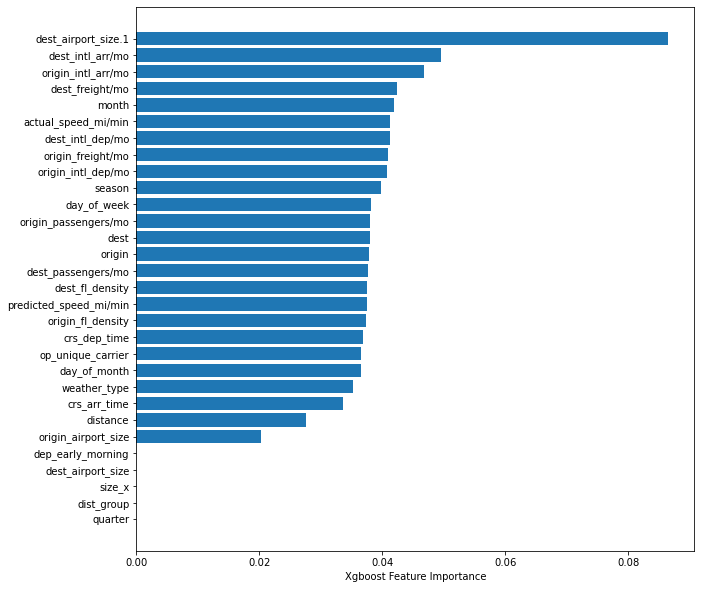

In [28]:
plt.rcParams['figure.figsize'] = [10, 10]
sorted_idx = model.feature_importances_.argsort()
plt.barh(flights[cols].columns[sorted_idx], model.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")
plt.show()

### XGB One Hot with all new cat columns

In [73]:
# XGB Classifier - Balanced Dataset - Onehot Encoding
# New features added all

# Select Features and Assign X and y
cols = ['distance', 'crs_arr_time', 'crs_dep_time', 'day_of_month', 'month', 'day_of_week', 'op_unique_carrier', 'origin', 'dest', 'weather_type', 
        'origin_fl_density', 'dest_fl_density', 'crs_arr_daytime', 'crs_dep_daytime',
        'predicted_speed_mi/min', 'actual_speed_mi/min', 'origin_passengers/mo', 'dest_passengers/mo', 
        'origin_freight/mo', 'dest_freight/mo', 'origin_intl_dep/mo', 'dest_intl_dep/mo', 'origin_intl_arr/mo', 'dest_intl_arr/mo',
        'origin_airport_size', 'dest_airport_size', 'size_x', 'dist_group', 'season', 'dep_early_morning'
       ] 

X = flights[cols]
y = flights['arr_delay_flag']

# encode categorical columns
#from sklearn import preprocessing
#label_encoder = preprocessing.LabelEncoder()
#cat_vars = X.select_dtypes(include= 'object').columns.tolist()
#for col in cat_vars:
#    X[col] = label_encoder.fit_transform(X[col])

#Onehot encoding
cat_vars = ['day_of_month', 'month', 'day_of_week', 'op_unique_carrier', 'origin', 'dest', 'weather_type',
           'crs_arr_daytime', 'crs_dep_daytime', 
           'origin_airport_size', 'dest_airport_size', 'size_x', 'dist_group', 'season', 'dep_early_morning'
           ]
X = pd.get_dummies(X, columns=cat_vars)

# Make train-test split and scale if needed
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#Xsc = scaler.fit_transform(X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=101)

#Model
import xgboost as xgb
model = xgb.XGBClassifier(objective = 'reg:squarederror')
model = model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#Evaluate
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_recall_curve
from sklearn.metrics import average_precision_score,roc_auc_score, confusion_matrix, plot_confusion_matrix, precision_score
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_pred))

C:\Users\Ryan\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


              precision    recall  f1-score   support

           0       0.51      0.51      0.51      7461
           1       0.52      0.52      0.52      7539

    accuracy                           0.51     15000
   macro avg       0.51      0.51      0.51     15000
weighted avg       0.51      0.51      0.51     15000

Accuracy: 0.5131333333333333
F1 Score: 0.5172208633569115
Recall: 0.5189017111022682
Precision: 0.5155508697944122
AUC Score: 0.5131031809766803


### XGB Classification Few Variables

In [72]:
# XGB Classifier - Balanced Dataset - Onehot Encoding
# New features added all

# Select Features and Assign X and y
cols = ['distance', 'crs_arr_hour', 'crs_dep_hour', 
        'day_of_month', 'month', 'day_of_week', 'op_unique_carrier', 'origin', 'dest', 'weather_type', 
       ] 


X = flights[cols]
y = flights['arr_delay_flag']

# encode categorical columns
#from sklearn import preprocessing
#label_encoder = preprocessing.LabelEncoder()
#cat_vars = X.select_dtypes(include= 'object').columns.tolist()
#for col in cat_vars:
#    X[col] = label_encoder.fit_transform(X[col])

#Onehot encoding
cat_vars = ['crs_arr_hour', 'crs_dep_hour', 'day_of_month', 'month', 'day_of_week', 'op_unique_carrier', 'origin', 'dest', 'weather_type']
X = pd.get_dummies(X, columns=cat_vars)

# Make train-test split and scale if needed
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#Xsc = scaler.fit_transform(X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=101)

#Model
import xgboost as xgb
model = xgb.XGBClassifier(objective = 'reg:squarederror')
model = model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#Evaluate
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_recall_curve
from sklearn.metrics import average_precision_score,roc_auc_score, confusion_matrix, plot_confusion_matrix, precision_score
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_pred))

C:\Users\Ryan\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


              precision    recall  f1-score   support

           0       0.52      0.49      0.50      7461
           1       0.52      0.55      0.54      7539

    accuracy                           0.52     15000
   macro avg       0.52      0.52      0.52     15000
weighted avg       0.52      0.52      0.52     15000

Accuracy: 0.5196
F1 Score: 0.5366512345679012
Recall: 0.5535216872264226
Precision: 0.5207787345563459
AUC Score: 0.5194226851894075


### XGB New Features

In [75]:
# XGB Classifier - Balanced Dataset - Onehot Encoding
# New features added all

# Select Features and Assign X and y
cols = ['distance', 'crs_arr_time', 'crs_dep_time', 
        'day_of_month', 'month', 'day_of_week', 'op_unique_carrier', 'origin', 'dest', 'weather_type', 
        'origin_fl_density', 'dest_fl_density', 'crs_arr_daytime', 'crs_dep_daytime',
        'predicted_speed_mi/min',
        'origin_airport_size', 'dest_airport_size', 'size_x', 'dist_group', 'season', 'dep_early_morning'
       ] 

X = flights[cols]
y = flights['arr_delay_flag']

# Label encoding
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
#cat_vars = X.select_dtypes(include= 'object').columns.tolist()
cat_vars = ['day_of_month', 'month', 'day_of_week', 'op_unique_carrier', 'origin', 'dest', 'weather_type',
           'crs_arr_daytime', 'crs_dep_daytime', 
           'origin_airport_size', 'dest_airport_size', 'size_x', 'dist_group', 'season', 'dep_early_morning'
           ]
for col in cat_vars:
    X[col] = label_encoder.fit_transform(X[col])

#Onehot encoding
#cat_vars = ['day_of_month', 'month', 'day_of_week', 'op_unique_carrier', 'origin', 'dest', 'weather_type',
#           'crs_arr_daytime', 'crs_dep_daytime', 
#           'origin_airport_size', 'dest_airport_size', 'size_x', 'dist_group', 'season', 'dep_early_morning'
#           ]
#X = pd.get_dummies(X, columns=cat_vars)

# Make train-test split and scale if needed
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#Xsc = scaler.fit_transform(X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=101)

#Model
import xgboost as xgb
model = xgb.XGBClassifier(objective = 'reg:squarederror')
model = model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#Evaluate
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_recall_curve
from sklearn.metrics import average_precision_score,roc_auc_score, confusion_matrix, plot_confusion_matrix, precision_score
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_pred))

<ipython-input-75-051cfd8d4dd8>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = label_encoder.fit_transform(X[col])
C:\Users\Ryan\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


              precision    recall  f1-score   support

           0       0.51      0.51      0.51      7461
           1       0.52      0.52      0.52      7539

    accuracy                           0.52     15000
   macro avg       0.52      0.52      0.52     15000
weighted avg       0.52      0.52      0.52     15000

Accuracy: 0.5150666666666667
F1 Score: 0.5197411857916281
Recall: 0.5220851571826503
Precision: 0.5174181674773235
AUC Score: 0.5150299797439856


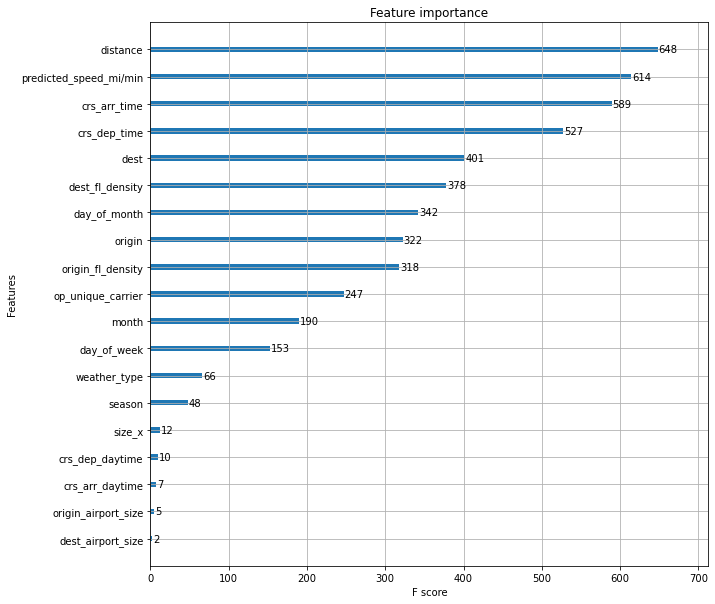

In [76]:
# Plot XGB Feature Importance
# .set_yticklabels(cols)
fig = xgb.plot_importance(model)
#fig.set_yticklabels(cols)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

### XGB New Features Label Encoding

In [100]:
# XGB Classifier - Balanced Dataset - Onehot Encoding
# New features added all

# Select Features and Assign X and y
cols = ['distance', 'crs_arr_time', 'crs_dep_time', 
        'day_of_month', 'month', 'day_of_week', 'op_unique_carrier', 'origin', 'dest', 'weather_type', 
        'origin_fl_density', 'dest_fl_density', 'crs_arr_daytime', 'crs_dep_daytime',
        'predicted_speed',
        'origin_airport_size', 'dest_airport_size', 'dist_group', 'season', 'dep_early_morning'
       ] 

X = flights[cols]
y = flights['arr_delay_flag']

# Label encoding
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
#cat_vars = X.select_dtypes(include= 'object').columns.tolist()
cat_vars = ['day_of_month', 'month', 'day_of_week', 'op_unique_carrier', 'origin', 'dest', 'weather_type',
           'crs_arr_daytime', 'crs_dep_daytime', 
           'origin_airport_size', 'dest_airport_size', 'dist_group', 'season', 'dep_early_morning'
           ]
for col in cat_vars:
    X[col] = label_encoder.fit_transform(X[col])

#Onehot encoding
#cat_vars = ['day_of_month', 'month', 'day_of_week', 'op_unique_carrier', 'origin', 'dest', 'weather_type',
#           'crs_arr_daytime', 'crs_dep_daytime', 
#           'origin_airport_size', 'dest_airport_size', 'size_x', 'dist_group', 'season', 'dep_early_morning'
#           ]
#X = pd.get_dummies(X, columns=cat_vars)

# Make train-test split and scale if needed
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#Xsc = scaler.fit_transform(X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=101)

#Model
import xgboost as xgb
model = xgb.XGBClassifier(objective = 'reg:squarederror')
model = model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#Evaluate
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_recall_curve
from sklearn.metrics import average_precision_score,roc_auc_score, confusion_matrix, plot_confusion_matrix, precision_score
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_pred))

<ipython-input-100-17b0be3ea898>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = label_encoder.fit_transform(X[col])
C:\Users\Ryan\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


              precision    recall  f1-score   support

           0       0.52      0.51      0.52      7461
           1       0.52      0.52      0.52      7539

    accuracy                           0.52     15000
   macro avg       0.52      0.52      0.52     15000
weighted avg       0.52      0.52      0.52     15000

Accuracy: 0.5198666666666667
F1 Score: 0.5235512040222281
Recall: 0.5248706725029845
Precision: 0.5222383529101228
AUC Score: 0.5198405098207188


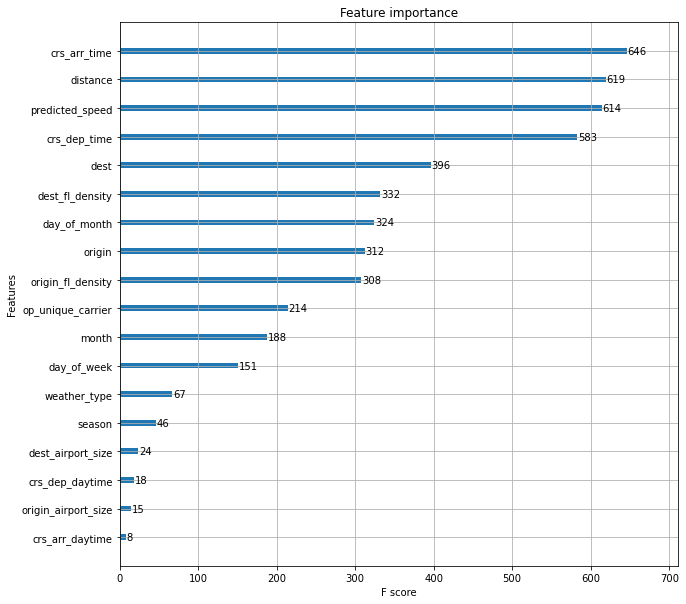

In [101]:
# Plot XGB Feature Importance
fig = xgb.plot_importance(model)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

### XGB New Features One Hot Encoding - Hyperparam Tuning - Best Model So Far

In [125]:
# XGB Classifier - Balanced Dataset - Onehot Encoding
# New features added all

# Select Features and Assign X and y
cols = ['distance', 'crs_arr_time', 'crs_dep_time', 
        'day_of_month', 'month', 'day_of_week', 'op_unique_carrier', 'origin', 'dest', 'weather_type', 
        'origin_fl_density', 'dest_fl_density', 'crs_arr_daytime', 'crs_dep_daytime',
        'predicted_speed',
        'origin_airport_size', 'dest_airport_size', 'dist_group', 'season', 'dep_early_morning'
       ] 

X = flights[cols]
y = flights['arr_delay_flag']

# Label encoding
#from sklearn import preprocessing
#label_encoder = preprocessing.LabelEncoder()
#cat_vars = X.select_dtypes(include= 'object').columns.tolist()
#cat_vars = ['day_of_month', 'month', 'day_of_week', 'op_unique_carrier', 'origin', 'dest', 'weather_type',
#           'crs_arr_daytime', 'crs_dep_daytime', 
#           'origin_airport_size', 'dest_airport_size', 'dist_group', 'season', 'dep_early_morning'
#           ]
#for col in cat_vars:
#    X[col] = label_encoder.fit_transform(X[col])

#Onehot encoding
cat_vars = ['day_of_month', 'month', 'day_of_week', 'op_unique_carrier', 'origin', 'dest', 'weather_type',
           'crs_arr_daytime', 'crs_dep_daytime', 
           'origin_airport_size', 'dest_airport_size', 'dist_group', 'season', 'dep_early_morning'
           ]
X = pd.get_dummies(X, columns=cat_vars)

# Make train-test split and scale if needed
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#Xsc = scaler.fit_transform(X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=101)

#Model
import xgboost as xgb
model = xgb.XGBClassifier(objective = 'reg:squarederror', n_estimators=300, learning_rate=0.01, max_depth=8)
#model = xgb.XGBClassifier(objective = 'reg:squarederror')  binary:logistic
model = model.fit(X_train, y_train) 
y_pred = model.predict(X_test)
y_score = model.predict_proba(X_test)[:,1]

#Evaluate
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_recall_curve
from sklearn.metrics import average_precision_score,roc_auc_score, confusion_matrix, plot_confusion_matrix, precision_score
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_score))

C:\Users\Ryan\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


              precision    recall  f1-score   support

           0       0.52      0.38      0.44      7461
           1       0.52      0.65      0.58      7539

    accuracy                           0.52     15000
   macro avg       0.52      0.52      0.51     15000
weighted avg       0.52      0.52      0.51     15000

Accuracy: 0.5174
F1 Score: 0.5753505015545257
Recall: 0.6504841490913914
Precision: 0.515776188472865
AUC Score: 0.5244875065866226


### RF Classifier

In [120]:
# RF Classifier - Balanced Dataset - Onehot Encoding
# New features added all

# Select Features and Assign X and y
cols = ['distance', 'crs_arr_time', 'crs_dep_time', 
        'day_of_month', 'month', 'day_of_week', 'op_unique_carrier', 'origin', 'dest', 'weather_type', 
        'origin_fl_density', 'dest_fl_density', 'crs_arr_daytime', 'crs_dep_daytime',
        'predicted_speed',
        'origin_airport_size', 'dest_airport_size', 'dist_group', 'season', 'dep_early_morning'
       ] 

X = flights[cols]
y = flights['arr_delay_flag']

# Label encoding
#from sklearn import preprocessing
#label_encoder = preprocessing.LabelEncoder()
#cat_vars = X.select_dtypes(include= 'object').columns.tolist()
#cat_vars = ['day_of_month', 'month', 'day_of_week', 'op_unique_carrier', 'origin', 'dest', 'weather_type',
#           'crs_arr_daytime', 'crs_dep_daytime', 
#           'origin_airport_size', 'dest_airport_size', 'dist_group', 'season', 'dep_early_morning'
#           ]
#for col in cat_vars:
#    X[col] = label_encoder.fit_transform(X[col])

#Onehot encoding
cat_vars = ['day_of_month', 'month', 'day_of_week', 'op_unique_carrier', 'origin', 'dest', 'weather_type',
           'crs_arr_daytime', 'crs_dep_daytime', 
           'origin_airport_size', 'dest_airport_size', 'dist_group', 'season', 'dep_early_morning'
           ]
X = pd.get_dummies(X, columns=cat_vars)

# Make train-test split and scale if needed
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#Xsc = scaler.fit_transform(X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=101)

#Model
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
model = RandomForestClassifier(n_estimators=500)
model = model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_score = model.predict_proba(X_test)[:,1]

#Evaluate
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_recall_curve
from sklearn.metrics import average_precision_score,roc_auc_score, confusion_matrix, plot_confusion_matrix, precision_score
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_score))

              precision    recall  f1-score   support

           0       0.52      0.51      0.52      7461
           1       0.53      0.54      0.53      7539

    accuracy                           0.52     15000
   macro avg       0.52      0.52      0.52     15000
weighted avg       0.52      0.52      0.52     15000

Accuracy: 0.5246
F1 Score: 0.5315025294001708
Recall: 0.5365433081310519
Precision: 0.5265555844832075
AUC Score: 0.535611869611621


### XGB Hyperparam Tuning

In [126]:
# XGB Classifier - Balanced Dataset - Onehot Encoding
# New features added all
# Best model so far tuning hyperparams

# Select Features and Assign X and y
cols = ['distance', 'crs_arr_time', 'crs_dep_time', 
        'day_of_month', 'month', 'day_of_week', 'op_unique_carrier', 'origin', 'dest', 'weather_type', 
        'origin_fl_density', 'dest_fl_density', 'crs_arr_daytime', 'crs_dep_daytime',
        'predicted_speed',
        'origin_airport_size', 'dest_airport_size', 'dist_group', 'season', 'dep_early_morning'
       ] 

X = flights[cols]
y = flights['arr_delay_flag']

# Label encoding
#from sklearn import preprocessing
#label_encoder = preprocessing.LabelEncoder()
#cat_vars = X.select_dtypes(include= 'object').columns.tolist()
#cat_vars = ['day_of_month', 'month', 'day_of_week', 'op_unique_carrier', 'origin', 'dest', 'weather_type',
#           'crs_arr_daytime', 'crs_dep_daytime', 
#           'origin_airport_size', 'dest_airport_size', 'dist_group', 'season', 'dep_early_morning'
#           ]
#for col in cat_vars:
#    X[col] = label_encoder.fit_transform(X[col])

#Onehot encoding
cat_vars = ['day_of_month', 'month', 'day_of_week', 'op_unique_carrier', 'origin', 'dest', 'weather_type',
           'crs_arr_daytime', 'crs_dep_daytime', 
           'origin_airport_size', 'dest_airport_size', 'dist_group', 'season', 'dep_early_morning'
           ]
X = pd.get_dummies(X, columns=cat_vars)

# Make train-test split and scale if needed
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#Xsc = scaler.fit_transform(X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=101)

#Model
import xgboost as xgb
model = xgb.XGBClassifier(objective = 'reg:squarederror', n_estimators=400, learning_rate=0.001, max_depth=10)
#model = xgb.XGBClassifier(objective = 'reg:squarederror')  binary:logistic
model = model.fit(X_train, y_train) 
y_pred = model.predict(X_test)
y_score = model.predict_proba(X_test)[:,1]

#Evaluate
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_recall_curve
from sklearn.metrics import average_precision_score,roc_auc_score, confusion_matrix, plot_confusion_matrix, precision_score
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_score))

C:\Users\Ryan\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


              precision    recall  f1-score   support

           0       0.52      0.35      0.42      7461
           1       0.52      0.68      0.59      7539

    accuracy                           0.52     15000
   macro avg       0.52      0.52      0.51     15000
weighted avg       0.52      0.52      0.51     15000

Accuracy: 0.5191333333333333
F1 Score: 0.5881345286358705
Recall: 0.6831144714153071
Precision: 0.5163424904752356
AUC Score: 0.5182619426918194


In [128]:
# XGB Classifier - Balanced Dataset - Onehot Encoding
# New features added all
# Change to objective logistic

# Select Features and Assign X and y
cols = ['distance', 'crs_arr_time', 'crs_dep_time', 
        'day_of_month', 'month', 'day_of_week', 'op_unique_carrier', 'origin', 'dest', 'weather_type', 
        'origin_fl_density', 'dest_fl_density', 'crs_arr_daytime', 'crs_dep_daytime',
        'predicted_speed',
        'origin_airport_size', 'dest_airport_size', 'dist_group', 'season', 'dep_early_morning'
       ] 

X = flights[cols]
y = flights['arr_delay_flag']

# Label encoding
#from sklearn import preprocessing
#label_encoder = preprocessing.LabelEncoder()
#cat_vars = X.select_dtypes(include= 'object').columns.tolist()
#cat_vars = ['day_of_month', 'month', 'day_of_week', 'op_unique_carrier', 'origin', 'dest', 'weather_type',
#           'crs_arr_daytime', 'crs_dep_daytime', 
#           'origin_airport_size', 'dest_airport_size', 'dist_group', 'season', 'dep_early_morning'
#           ]
#for col in cat_vars:
#    X[col] = label_encoder.fit_transform(X[col])

#Onehot encoding
cat_vars = ['day_of_month', 'month', 'day_of_week', 'op_unique_carrier', 'origin', 'dest', 'weather_type',
           'crs_arr_daytime', 'crs_dep_daytime', 
           'origin_airport_size', 'dest_airport_size', 'dist_group', 'season', 'dep_early_morning'
           ]
X = pd.get_dummies(X, columns=cat_vars)

# Make train-test split and scale if needed
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#Xsc = scaler.fit_transform(X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=101)

#Model
import xgboost as xgb
model = xgb.XGBClassifier(objective = 'reg:logistic', n_estimators=400, learning_rate=0.001, max_depth=10)
#model = xgb.XGBClassifier(objective = 'reg:squarederror')  binary:logistic
model = model.fit(X_train, y_train) 
y_pred = model.predict(X_test)
y_score = model.predict_proba(X_test)[:,1]

#Evaluate
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_recall_curve
from sklearn.metrics import average_precision_score,roc_auc_score, confusion_matrix, plot_confusion_matrix, precision_score
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_score))

C:\Users\Ryan\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


              precision    recall  f1-score   support

           0       0.53      0.36      0.43      7461
           1       0.52      0.68      0.59      7539

    accuracy                           0.52     15000
   macro avg       0.52      0.52      0.51     15000
weighted avg       0.52      0.52      0.51     15000

Accuracy: 0.5224666666666666
F1 Score: 0.5898654451760664
Recall: 0.6832471150019896
Precision: 0.5189401571630062
AUC Score: 0.5219661850767556


In [134]:
# XGB Classifier - Balanced Dataset - Onehot Encoding
# New features added all
# Best model so far tuning hyperparams

# Select Features and Assign X and y
cols = ['distance', 'crs_arr_time', 'crs_dep_time', 
        'day_of_month', 'month', 'day_of_week', 'op_unique_carrier', 'origin', 'dest', 'weather_type', 
        'origin_fl_density', 'dest_fl_density', 'crs_arr_daytime', 'crs_dep_daytime',
        'predicted_speed',
        'origin_airport_size', 'dest_airport_size', 'dist_group', 'season', 'dep_early_morning'
       ] 

X = flights[cols]
y = flights['arr_delay_flag']

# Label encoding
#from sklearn import preprocessing
#label_encoder = preprocessing.LabelEncoder()
#cat_vars = X.select_dtypes(include= 'object').columns.tolist()
#cat_vars = ['day_of_month', 'month', 'day_of_week', 'op_unique_carrier', 'origin', 'dest', 'weather_type',
#           'crs_arr_daytime', 'crs_dep_daytime', 
#           'origin_airport_size', 'dest_airport_size', 'dist_group', 'season', 'dep_early_morning'
#           ]
#for col in cat_vars:
#    X[col] = label_encoder.fit_transform(X[col])

#Onehot encoding
cat_vars = ['day_of_month', 'month', 'day_of_week', 'op_unique_carrier', 'origin', 'dest', 'weather_type',
           'crs_arr_daytime', 'crs_dep_daytime', 
           'origin_airport_size', 'dest_airport_size', 'dist_group', 'season', 'dep_early_morning'
           ]
X = pd.get_dummies(X, columns=cat_vars)

# Make train-test split and scale if needed
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#Xsc = scaler.fit_transform(X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=101)

#Model
import xgboost as xgb
model = xgb.XGBClassifier(objective = 'reg:squarederror', n_estimators=1000, learning_rate=0.001, max_depth=10)
#model = xgb.XGBClassifier(objective = 'reg:squarederror')  binary:logistic
model = model.fit(X_train, y_train) 
y_pred = model.predict(X_test)
y_score = model.predict_proba(X_test)[:,1]

#Evaluate
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_recall_curve
from sklearn.metrics import average_precision_score,roc_auc_score, confusion_matrix, plot_confusion_matrix, precision_score
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_score))

C:\Users\Ryan\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


              precision    recall  f1-score   support

           0       0.52      0.33      0.41      7461
           1       0.51      0.70      0.59      7539

    accuracy                           0.52     15000
   macro avg       0.52      0.52      0.50     15000
weighted avg       0.52      0.52      0.50     15000

Accuracy: 0.5162666666666667
F1 Score: 0.5918551018112274
Recall: 0.6978379095370739
Precision: 0.5138197089559527
AUC Score: 0.5184729795093659


In [138]:
# XGB Classifier - Balanced Dataset - Onehot Encoding
# New features added all
# Best model so far tuning hyperparams

# Select Features and Assign X and y
cols = ['distance', 'crs_arr_time', 'crs_dep_time', 
        'day_of_month', 'month', 'day_of_week', 'op_unique_carrier', 'origin', 'dest', 'weather_type', 
        'origin_fl_density', 'dest_fl_density', 'crs_arr_daytime', 'crs_dep_daytime',
        'predicted_speed',
        'origin_airport_size', 'dest_airport_size', 'dist_group', 'season', 'dep_early_morning'
       ] 

X = flights[cols]
y = flights['arr_delay_flag']

# Label encoding
#from sklearn import preprocessing
#label_encoder = preprocessing.LabelEncoder()
#cat_vars = X.select_dtypes(include= 'object').columns.tolist()
#cat_vars = ['day_of_month', 'month', 'day_of_week', 'op_unique_carrier', 'origin', 'dest', 'weather_type',
#           'crs_arr_daytime', 'crs_dep_daytime', 
#           'origin_airport_size', 'dest_airport_size', 'dist_group', 'season', 'dep_early_morning'
#           ]
#for col in cat_vars:
#    X[col] = label_encoder.fit_transform(X[col])

#Onehot encoding
cat_vars = ['day_of_month', 'month', 'day_of_week', 'op_unique_carrier', 'origin', 'dest', 'weather_type',
           'crs_arr_daytime', 'crs_dep_daytime', 
           'origin_airport_size', 'dest_airport_size', 'dist_group', 'season', 'dep_early_morning'
           ]
X = pd.get_dummies(X, columns=cat_vars)

# Make train-test split and scale if needed
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#Xsc = scaler.fit_transform(X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=101)

#Model
import xgboost as xgb
model = xgb.XGBClassifier(objective = 'reg:squarederror', n_estimators=500, learning_rate=0.001, max_depth=10)
#model = xgb.XGBClassifier(objective = 'reg:squarederror')  binary:logistic
model = model.fit(X_train, y_train) 
y_pred = model.predict(X_test)
y_score = model.predict_proba(X_test)[:,1]

#Evaluate
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_recall_curve
from sklearn.metrics import average_precision_score,roc_auc_score, confusion_matrix, plot_confusion_matrix, precision_score
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_score))

C:\Users\Ryan\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


              precision    recall  f1-score   support

           0       0.52      0.33      0.40      7461
           1       0.51      0.70      0.59      7539

    accuracy                           0.52     15000
   macro avg       0.52      0.52      0.50     15000
weighted avg       0.52      0.52      0.50     15000

Accuracy: 0.518
F1 Score: 0.5949579831932772
Recall: 0.7043374452845205
Precision: 0.5149839976723887
AUC Score: 0.5189279607009463


# Mini-Sample Dataset 15min Cutoff for Delay and No Delay Balanced Dataset
### Using Best XGB Model

In [192]:
# XGB Classifier - Balanced Dataset - Onehot Encoding
# New features added all
# Best model so far tuning hyperparams

# Select Features and Assign X and y
cols = ['distance', 'crs_arr_time', 'crs_dep_time', 
        'day_of_month', 'month', 'day_of_week', 'op_unique_carrier', 'origin', 'dest', 'weather_type', 
        'origin_fl_density', 'dest_fl_density', 'crs_arr_daytime', 'crs_dep_daytime',
        'predicted_speed',
        'origin_airport_size', 'dest_airport_size', 'dist_group', 'season', 'dep_early_morning'
       ] 

X = flights[cols]
y = flights['arr_delay_flag']

# Label encoding
#from sklearn import preprocessing
#label_encoder = preprocessing.LabelEncoder()
#cat_vars = X.select_dtypes(include= 'object').columns.tolist()
#cat_vars = ['day_of_month', 'month', 'day_of_week', 'op_unique_carrier', 'origin', 'dest', 'weather_type',
#           'crs_arr_daytime', 'crs_dep_daytime', 
#           'origin_airport_size', 'dest_airport_size', 'dist_group', 'season', 'dep_early_morning'
#           ]
#for col in cat_vars:
#    X[col] = label_encoder.fit_transform(X[col])

#Onehot encoding
cat_vars = ['day_of_month', 'month', 'day_of_week', 'op_unique_carrier', 'origin', 'dest', 'weather_type',
           'crs_arr_daytime', 'crs_dep_daytime', 
           'origin_airport_size', 'dest_airport_size', 'dist_group', 'season', 'dep_early_morning'
           ]
X = pd.get_dummies(X, columns=cat_vars)

# Make train-test split and scale if needed
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#Xsc = scaler.fit_transform(X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=101)

#Model
import xgboost as xgb
model = xgb.XGBClassifier(objective = 'reg:squarederror', n_estimators=100, learning_rate=0.001, max_depth=10)
#model = xgb.XGBClassifier(objective = 'reg:squarederror')  binary:logistic
model = model.fit(X_train, y_train) 
y_pred = model.predict(X_test)
y_score = model.predict_proba(X_test)[:,1]

#Evaluate
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_recall_curve
from sklearn.metrics import average_precision_score,roc_auc_score, confusion_matrix, plot_confusion_matrix, precision_score
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_score))

C:\Users\Ryan\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


              precision    recall  f1-score   support

           0       0.52      0.71      0.60      7764
           1       0.49      0.30      0.37      7236

    accuracy                           0.51     15000
   macro avg       0.50      0.50      0.49     15000
weighted avg       0.51      0.51      0.49     15000

Accuracy: 0.5112
F1 Score: 0.37204522096608433
Recall: 0.30016583747927034
Precision: 0.4891891891891892
AUC Score: 0.511736559844888


In [193]:
flights['arr_delay_flag'].value_counts()

0    25869
1    24129
Name: arr_delay_flag, dtype: int64

Text(0.5, 637.6, 'Predicted label')

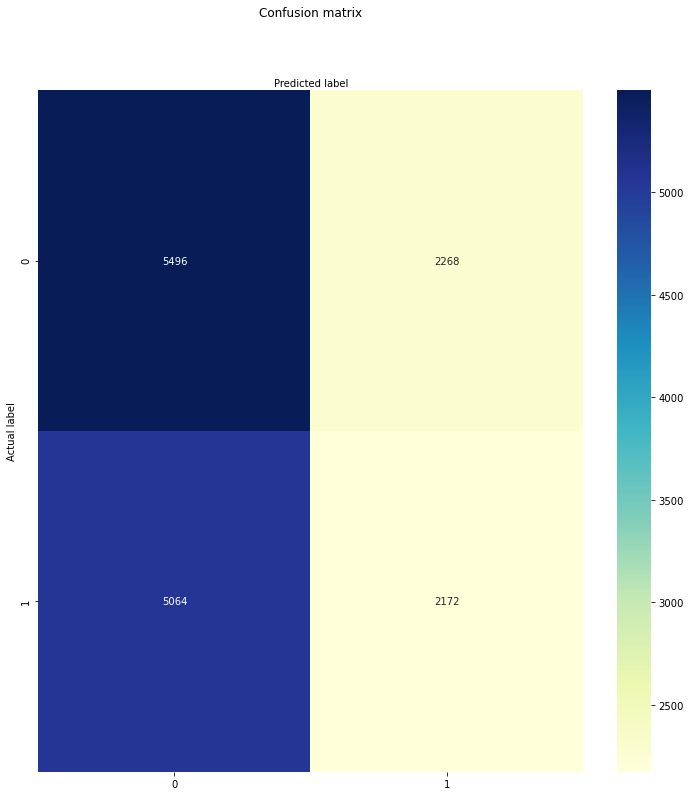

In [194]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

# create heatmap
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Mini-Sample Dataset Back To 0min Cutoff for Delay and No Delay Balanced Dataset

### Using Best XGB Model (Label Encoding for Feature Importance)

In [199]:
# XGB Classifier - Balanced Dataset - Onehot Encoding
# New features added all
# Best model so far tuning hyperparams

# Select Features and Assign X and y
cols = ['distance', 'crs_arr_time', 'crs_dep_time', 
        'day_of_month', 'month', 'day_of_week', 'op_unique_carrier', 'origin', 'dest', 'weather_type', 
        'origin_fl_density', 'dest_fl_density', 'crs_arr_daytime', 'crs_dep_daytime',
        'predicted_speed',
        'origin_airport_size', 'dest_airport_size', 'dist_group', 'season', 'dep_early_morning'
       ] 

X = flights[cols]
y = flights['arr_delay_flag']

#Label encoding
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
#cat_vars = X.select_dtypes(include= 'object').columns.tolist()
cat_vars = ['day_of_month', 'month', 'day_of_week', 'op_unique_carrier', 'origin', 'dest', 'weather_type',
           'crs_arr_daytime', 'crs_dep_daytime', 
           'origin_airport_size', 'dest_airport_size', 'dist_group', 'season', 'dep_early_morning'
           ]
for col in cat_vars:
    X[col] = label_encoder.fit_transform(X[col])

#Onehot encoding
#cat_vars = ['day_of_month', 'month', 'day_of_week', 'op_unique_carrier', 'origin', 'dest', 'weather_type',
#           'crs_arr_daytime', 'crs_dep_daytime', 
#           'origin_airport_size', 'dest_airport_size', 'dist_group', 'season', 'dep_early_morning'
#           ]
#X = pd.get_dummies(X, columns=cat_vars)

# Make train-test split and scale if needed
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#Xsc = scaler.fit_transform(X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=101)

#Model
import xgboost as xgb
model = xgb.XGBClassifier(objective = 'reg:squarederror', n_estimators=1000, learning_rate=0.001, max_depth=10)
#model = xgb.XGBClassifier(objective = 'reg:squarederror')  binary:logistic
model = model.fit(X_train, y_train) 
y_pred = model.predict(X_test)
y_score = model.predict_proba(X_test)[:,1]

#Evaluate
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_recall_curve
from sklearn.metrics import average_precision_score,roc_auc_score, confusion_matrix, plot_confusion_matrix, precision_score
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_score))

<ipython-input-199-8dbde3467789>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = label_encoder.fit_transform(X[col])
C:\Users\Ryan\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


              precision    recall  f1-score   support

           0       0.51      0.48      0.50      7461
           1       0.52      0.55      0.53      7539

    accuracy                           0.52     15000
   macro avg       0.52      0.52      0.51     15000
weighted avg       0.52      0.52      0.51     15000

Accuracy: 0.5153333333333333
F1 Score: 0.5309677419354838
Recall: 0.5458283591988328
Precision: 0.5168948624544655
AUC Score: 0.5224445713456536


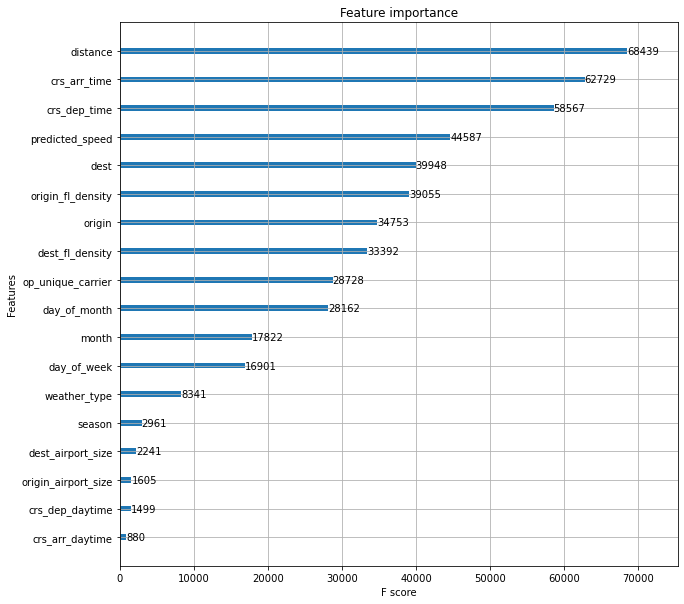

In [200]:
# Plot XGB Feature Importance
fig = xgb.plot_importance(model)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

### Using Best XGB Model (Back To One Hot Encoding)

In [214]:
# XGB Classifier - Balanced Dataset - Onehot Encoding
# New features added all
# Best model so far tuning hyperparams

# Select Features and Assign X and y
cols = ['distance', 'crs_arr_time', 'crs_dep_time', 
        'day_of_month', 'month', 'day_of_week', 'op_unique_carrier', 'origin', 'dest', 'weather_type', 
        'origin_fl_density', 'dest_fl_density', 'crs_arr_daytime', 'crs_dep_daytime',
        'predicted_speed',
        'origin_airport_size', 'dest_airport_size', 'dist_group', 'season', 'dep_early_morning'
       ] 

X = flights[cols]
y = flights['arr_delay_flag']

# Label encoding
#from sklearn import preprocessing
#label_encoder = preprocessing.LabelEncoder()
#cat_vars = X.select_dtypes(include= 'object').columns.tolist()
#cat_vars = ['day_of_month', 'month', 'day_of_week', 'op_unique_carrier', 'origin', 'dest', 'weather_type',
#           'crs_arr_daytime', 'crs_dep_daytime', 
#           'origin_airport_size', 'dest_airport_size', 'dist_group', 'season', 'dep_early_morning'
#           ]
#for col in cat_vars:
#    X[col] = label_encoder.fit_transform(X[col])

#Onehot encoding
cat_vars = ['day_of_month', 'month', 'day_of_week', 'op_unique_carrier', 'origin', 'dest', 'weather_type',
           'crs_arr_daytime', 'crs_dep_daytime', 
           'origin_airport_size', 'dest_airport_size', 'dist_group', 'season', 'dep_early_morning'
           ]
X = pd.get_dummies(X, columns=cat_vars)

# Make train-test split and scale if needed
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#Xsc = scaler.fit_transform(X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=101)

#Model
import xgboost as xgb
model = xgb.XGBClassifier(objective = 'reg:logistic', eval_metric='auc', n_estimators=1000, learning_rate=0.001, max_depth=10)
#model = xgb.XGBClassifier(objective = 'reg:squarederror')  binary:logistic
model = model.fit(X_train, y_train) 
y_pred = model.predict(X_test)
y_score = model.predict_proba(X_test)[:,1]

#Evaluate
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_recall_curve
from sklearn.metrics import average_precision_score,roc_auc_score, confusion_matrix, plot_confusion_matrix, precision_score
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_score))

C:\Users\Ryan\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


              precision    recall  f1-score   support

           0       0.52      0.34      0.41      7429
           1       0.52      0.69      0.59      7571

    accuracy                           0.52     15000
   macro avg       0.52      0.52      0.50     15000
weighted avg       0.52      0.52      0.50     15000

Accuracy: 0.5180666666666667
F1 Score: 0.5916972606608303
Recall: 0.6918504821027606
Precision: 0.5168738898756661
AUC Score: 0.5201080064793007


In [215]:
# Try Renees columns

# XGB Classifier - Balanced Dataset - Onehot Encoding
# New features added all
# Best model so far tuning hyperparams

# Select Features and Assign X and y
cols=['day', 'month', 'weekday', 'op_unique_carrier', 
      'origin', 'dest',
      'crs_arr_daytime', 'crs_dep_daytime', 
       'origin_airport_size', 'dest_airport_size', 
      'dist_group', 'season', 'dep_early_morning',
      'percent_delay_dep', 'dist_group_delay_ratio']

X = flights[cols]
y = flights['arr_delay_flag']

# Label encoding
#from sklearn import preprocessing
#label_encoder = preprocessing.LabelEncoder()
#cat_vars = X.select_dtypes(include= 'object').columns.tolist()
#cat_vars = ['day_of_month', 'month', 'day_of_week', 'op_unique_carrier', 'origin', 'dest', 'weather_type',
#           'crs_arr_daytime', 'crs_dep_daytime', 
#           'origin_airport_size', 'dest_airport_size', 'dist_group', 'season', 'dep_early_morning'
#           ]
#for col in cat_vars:
#    X[col] = label_encoder.fit_transform(X[col])

#Onehot encoding
cat_vars = ['day', 'month', 'weekday', 'op_unique_carrier', 'origin', 'dest',
           'crs_arr_daytime', 'crs_dep_daytime', 'origin_airport_size', 'dest_airport_size',
            'dist_group', 'season', 'dep_early_morning', 'percent_delay_dep', 'dist_group_delay_ratio'
           ]
X = pd.get_dummies(X, columns=cat_vars)

# Make train-test split and scale if needed
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#Xsc = scaler.fit_transform(X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=101)

#Model
import xgboost as xgb
model = xgb.XGBClassifier(objective = 'reg:logistic', eval_metric='auc', n_estimators=1000, learning_rate=0.001, max_depth=10)
#model = xgb.XGBClassifier(objective = 'reg:squarederror')  binary:logistic
model = model.fit(X_train, y_train) 
y_pred = model.predict(X_test)
y_score = model.predict_proba(X_test)[:,1]

#Evaluate
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_recall_curve
from sklearn.metrics import average_precision_score,roc_auc_score, confusion_matrix, plot_confusion_matrix, precision_score
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_score))

C:\Users\Ryan\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


              precision    recall  f1-score   support

           0       0.85      0.24      0.38      7429
           1       0.56      0.96      0.71      7571

    accuracy                           0.60     15000
   macro avg       0.70      0.60      0.54     15000
weighted avg       0.70      0.60      0.55     15000

Accuracy: 0.6037333333333333
F1 Score: 0.708969839404622
Recall: 0.9562805441817461
Precision: 0.5632926165097643
AUC Score: 0.6254482201684954


In [223]:
# Add 'ap_carr_percent_dep_delay'

# XGB Classifier - Balanced Dataset - Onehot Encoding
# New features added all
# Best model so far tuning hyperparams

# Select Features and Assign X and y
cols = ['distance', 'crs_arr_time', 'crs_dep_time', 
        'day_of_month', 'month', 'day_of_week', 'op_unique_carrier', 'origin', 'dest', 'weather_type', 
        'origin_fl_density', 'dest_fl_density', 'season',
        'predicted_speed',
        'origin_airport_size', 'dest_airport_size', 'dist_group', 'ap_carr_percent_dep_delay'
       ] 

X = flights[cols]
y = flights['arr_delay_flag']

# Label encoding
#from sklearn import preprocessing
#label_encoder = preprocessing.LabelEncoder()
#cat_vars = X.select_dtypes(include= 'object').columns.tolist()
#cat_vars = ['day_of_month', 'month', 'day_of_week', 'op_unique_carrier', 'origin', 'dest', 'weather_type',
#           'crs_arr_daytime', 'crs_dep_daytime', 
#           'origin_airport_size', 'dest_airport_size', 'dist_group', 'season', 'dep_early_morning'
#           ]
#for col in cat_vars:
#    X[col] = label_encoder.fit_transform(X[col])

#Onehot encoding
cat_vars = ['day_of_month', 'month', 'day_of_week', 'op_unique_carrier', 'origin', 'dest', 'weather_type',
           'origin_airport_size', 'dest_airport_size', 'dist_group', 'season'
           ]
X = pd.get_dummies(X, columns=cat_vars)

# Make train-test split and scale if needed
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#Xsc = scaler.fit_transform(X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=101)

#Model
import xgboost as xgb
model = xgb.XGBClassifier(objective = 'reg:logistic', eval_metric='auc', n_estimators=200, learning_rate=0.001, max_depth=10)
#model = xgb.XGBClassifier(objective = 'reg:squarederror')  binary:logistic
model = model.fit(X_train, y_train) 
y_pred = model.predict(X_test)
y_score = model.predict_proba(X_test)[:,1]

#Evaluate
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_recall_curve
from sklearn.metrics import average_precision_score,roc_auc_score, confusion_matrix, plot_confusion_matrix, precision_score
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_score))

C:\Users\Ryan\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


              precision    recall  f1-score   support

           0       0.53      0.36      0.43      7624
           1       0.50      0.68      0.58      7376

    accuracy                           0.51     15000
   macro avg       0.52      0.52      0.50     15000
weighted avg       0.52      0.51      0.50     15000

Accuracy: 0.5141333333333333
F1 Score: 0.5782895498206225
Recall: 0.6774674620390455
Precision: 0.5044417524732485
AUC Score: 0.5158167146276287


In [225]:
# Try Renees columns updated removed mean delay columns

# XGB Classifier - Balanced Dataset - Onehot Encoding
# New features added all
# Best model so far tuning hyperparams

# Select Features and Assign X and y
cols=['day', 'month', 'weekday', 'op_unique_carrier', 
      'origin', 'dest',
      'crs_arr_daytime', 'crs_dep_daytime', 
       'origin_airport_size', 'dest_airport_size', 
      'dist_group', 'season', 'dep_early_morning']

X = flights[cols]
y = flights['arr_delay_flag']

# Label encoding
#from sklearn import preprocessing
#label_encoder = preprocessing.LabelEncoder()
#cat_vars = X.select_dtypes(include= 'object').columns.tolist()
#cat_vars = ['day_of_month', 'month', 'day_of_week', 'op_unique_carrier', 'origin', 'dest', 'weather_type',
#           'crs_arr_daytime', 'crs_dep_daytime', 
#           'origin_airport_size', 'dest_airport_size', 'dist_group', 'season', 'dep_early_morning'
#           ]
#for col in cat_vars:
#    X[col] = label_encoder.fit_transform(X[col])

#Onehot encoding
cat_vars = ['day', 'month', 'weekday', 'op_unique_carrier', 'origin', 'dest',
           'crs_arr_daytime', 'crs_dep_daytime', 'origin_airport_size', 'dest_airport_size',
            'dist_group', 'season', 'dep_early_morning'
           ]
X = pd.get_dummies(X, columns=cat_vars)

# Make train-test split and scale if needed
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#Xsc = scaler.fit_transform(X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=101)

#Model
import xgboost as xgb
model = xgb.XGBClassifier(objective = 'reg:logistic', eval_metric='auc', n_estimators=200, learning_rate=0.001, max_depth=10)
#model = xgb.XGBClassifier(objective = 'reg:squarederror')  binary:logistic
model = model.fit(X_train, y_train) 
y_pred = model.predict(X_test)
y_score = model.predict_proba(X_test)[:,1]

#Evaluate
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_recall_curve
from sklearn.metrics import average_precision_score,roc_auc_score, confusion_matrix, plot_confusion_matrix, precision_score
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_score))

C:\Users\Ryan\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


              precision    recall  f1-score   support

           0       0.54      0.32      0.40      7624
           1       0.50      0.72      0.59      7376

    accuracy                           0.51     15000
   macro avg       0.52      0.52      0.50     15000
weighted avg       0.52      0.51      0.49     15000

Accuracy: 0.5148
F1 Score: 0.5929074840586196
Recall: 0.7185466377440347
Precision: 0.5046657779470577
AUC Score: 0.5228231898554172


# Best XGB Model with 200,000 rows of data

In [233]:
# 1000 Trees
# XGB Classifier - Balanced Dataset - Onehot Encoding
# New features added all
# Best model so far tuning hyperparams

# Select Features and Assign X and y
cols = ['distance', 'crs_arr_time', 'crs_dep_time', 
        'day_of_month', 'month', 'day_of_week', 'op_unique_carrier', 'origin', 'dest', 'weather_type', 
        'origin_fl_density', 'dest_fl_density', 'crs_arr_daytime', 'crs_dep_daytime',
        'predicted_speed',
        'origin_airport_size', 'dest_airport_size', 'dist_group', 'season', 'dep_early_morning'
       ] 

X = flights[cols]
y = flights['arr_delay_flag']

# Label encoding
#from sklearn import preprocessing
#label_encoder = preprocessing.LabelEncoder()
#cat_vars = X.select_dtypes(include= 'object').columns.tolist()
#cat_vars = ['day_of_month', 'month', 'day_of_week', 'op_unique_carrier', 'origin', 'dest', 'weather_type',
#           'crs_arr_daytime', 'crs_dep_daytime', 
#           'origin_airport_size', 'dest_airport_size', 'dist_group', 'season', 'dep_early_morning'
#           ]
#for col in cat_vars:
#    X[col] = label_encoder.fit_transform(X[col])

#Onehot encoding
cat_vars = ['day_of_month', 'month', 'day_of_week', 'op_unique_carrier', 'origin', 'dest', 'weather_type',
           'crs_arr_daytime', 'crs_dep_daytime', 
           'origin_airport_size', 'dest_airport_size', 'dist_group', 'season', 'dep_early_morning'
           ]
X = pd.get_dummies(X, columns=cat_vars)

# Make train-test split and scale if needed
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#Xsc = scaler.fit_transform(X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=101)

#Model
import xgboost as xgb
model = xgb.XGBClassifier(objective = 'reg:logistic', eval_metric='auc', n_estimators=1000, learning_rate=0.001, max_depth=10)
#model = xgb.XGBClassifier(objective = 'reg:squarederror')  binary:logistic
model = model.fit(X_train, y_train) 
y_pred = model.predict(X_test)
y_score = model.predict_proba(X_test)[:,1]

#Evaluate
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_recall_curve
from sklearn.metrics import average_precision_score,roc_auc_score, confusion_matrix, plot_confusion_matrix, precision_score
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_score))

              precision    recall  f1-score   support

           0       0.55      0.39      0.45     30078
           1       0.52      0.67      0.59     29921

    accuracy                           0.53     59999
   macro avg       0.53      0.53      0.52     59999
weighted avg       0.53      0.53      0.52     59999

Accuracy: 0.5310088501475024
F1 Score: 0.5886171254806216
Recall: 0.6728050533070419
Precision: 0.5231548856548857
AUC Score: 0.5467906022686214


Text(0.5, 637.6, 'Predicted label')

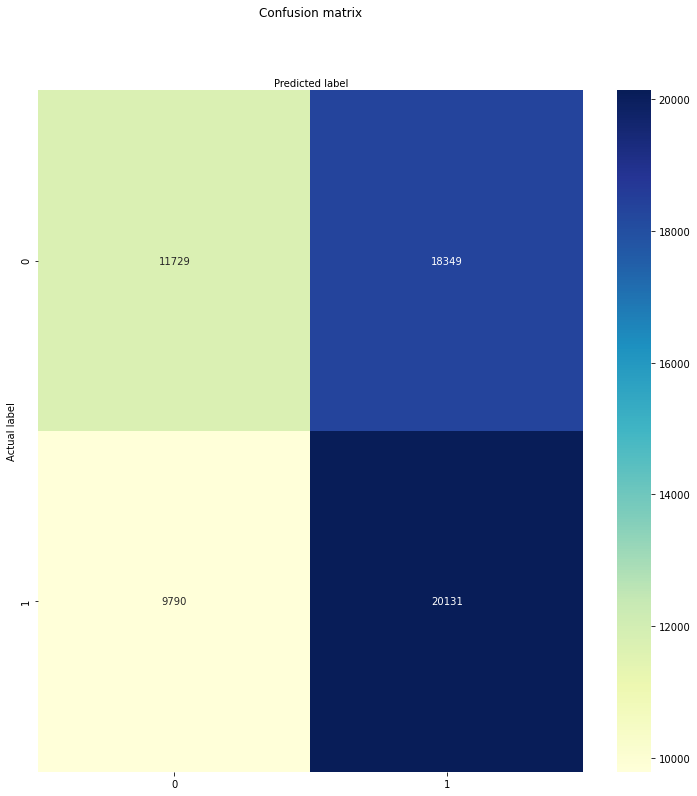

In [234]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

# create heatmap
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [235]:
# 10,000 Trees
# XGB Classifier - Balanced Dataset - Onehot Encoding
# New features added all
# Best model so far tuning hyperparams

# Select Features and Assign X and y
cols = ['distance', 'crs_arr_time', 'crs_dep_time', 
        'day_of_month', 'month', 'day_of_week', 'op_unique_carrier', 'origin', 'dest', 'weather_type', 
        'origin_fl_density', 'dest_fl_density', 'crs_arr_daytime', 'crs_dep_daytime',
        'predicted_speed',
        'origin_airport_size', 'dest_airport_size', 'dist_group', 'season', 'dep_early_morning'
       ] 

X = flights[cols]
y = flights['arr_delay_flag']

# Label encoding
#from sklearn import preprocessing
#label_encoder = preprocessing.LabelEncoder()
#cat_vars = X.select_dtypes(include= 'object').columns.tolist()
#cat_vars = ['day_of_month', 'month', 'day_of_week', 'op_unique_carrier', 'origin', 'dest', 'weather_type',
#           'crs_arr_daytime', 'crs_dep_daytime', 
#           'origin_airport_size', 'dest_airport_size', 'dist_group', 'season', 'dep_early_morning'
#           ]
#for col in cat_vars:
#    X[col] = label_encoder.fit_transform(X[col])

#Onehot encoding
cat_vars = ['day_of_month', 'month', 'day_of_week', 'op_unique_carrier', 'origin', 'dest', 'weather_type',
           'crs_arr_daytime', 'crs_dep_daytime', 
           'origin_airport_size', 'dest_airport_size', 'dist_group', 'season', 'dep_early_morning'
           ]
X = pd.get_dummies(X, columns=cat_vars)

# Make train-test split and scale if needed
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#Xsc = scaler.fit_transform(X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=101)

#Model
import xgboost as xgb
model2 = xgb.XGBClassifier(objective = 'reg:logistic', eval_metric='auc', n_estimators=10000, learning_rate=0.001, max_depth=10)
#model = xgb.XGBClassifier(objective = 'reg:squarederror')  binary:logistic
model2 = model2.fit(X_train, y_train) 
y_pred = model2.predict(X_test)
y_score = model2.predict_proba(X_test)[:,1]

#Evaluate
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_recall_curve
from sklearn.metrics import average_precision_score,roc_auc_score, confusion_matrix, plot_confusion_matrix, precision_score
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_score))

C:\Users\Ryan\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


              precision    recall  f1-score   support

           0       0.54      0.47      0.50     30078
           1       0.53      0.60      0.56     29921

    accuracy                           0.53     59999
   macro avg       0.53      0.53      0.53     59999
weighted avg       0.53      0.53      0.53     59999

Accuracy: 0.5330088834813913
F1 Score: 0.5619909643733684
Recall: 0.6007486380802781
Precision: 0.5279311560150376
AUC Score: 0.5472017476773328


In [231]:
flights['arr_delay_flag'].value_counts()

0    100209
1     99785
Name: arr_delay_flag, dtype: int64